# WIKIPEDIA PROJECT

In [96]:
import requests
import bs4
import re
from time import sleep
import random
import networkx as nx
import numpy as np 
import os

import nltk

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from nltk.tokenize import word_tokenize, wordpunct_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from scipy.spatial.distance import cosine


import logging
logger = logging.getLogger()


[nltk_data] Downloading package punkt to C:\Users\Windows
[nltk_data]     10\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Windows
[nltk_data]     10\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Windows
[nltk_data]     10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Scraping

We choose starting wikipedia articles (a few - in order to assure variety) and traverse the wikipedia web from one article to another. 
Each scraped article gets saved in the **/articles** folder with the title of the article as the name.

In [97]:
WIKIPEDIA_BASE_URL = "https://en.wikipedia.org"
PATH = r'c:\Users\Windows 10\NINA\UNI\SEM 5\IR\Wikipedia project' # TODO : get own path

In [100]:
def parse_page(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error in get request for {url}, status code: {response.status_code}")
    return bs4.BeautifulSoup(response.text)

In [99]:
def get_text_from_parsed_page(parsed):
    title = parsed.select('h1')[0]
    return title.getText(), ' '.join([p.getText() for p in parsed.select('p')]).replace('\n', ' ').replace('\[ [0-9] \]', ' ') #TODO: TRY OUT

In [6]:
def get_urls_from_parsed_page(parsed):
    links = [link['href'] for link in parsed.find_all('a', attrs={'href': re.compile(r'^/wiki')})]
    links = list(filter(lambda l: 'File:' not in l and 'Wikipedia:' not in l and 'Help:' not in l and 'Template:' not in l \
                        and 'Special:' not in l and 'Talk:' not in l and 'Portal:' not in l and 'Category:' not in l, links))
    return links

In [324]:
MAX_NUM_ITERATIONS = 1900
starting_links = ['https://en.wikipedia.org/wiki/Poland',
                    'https://en.wikipedia.org/wiki/Biology',
                    'https://pl.wikipedia.org/wiki/Noam_Chomsky',
                    'https://en.wikipedia.org/wiki/Chair']
os.chdir(PATH)

def web_searcher(url, list_of_links = [], iteration = 0):
    if iteration > MAX_NUM_ITERATIONS:
        return None
    parsed = parse_page(url)
    title, text = get_text_from_parsed_page(parsed)
    links = get_urls_from_parsed_page(parsed)

    with open(f'articles/{"-".join(title.replace("/","").replace("?","").split())}.txt', 'w', encoding='utf-8') as f:
        f.write(title)
        f.write(" \n ")
        f.write(text)

    random.shuffle(links)
    list_of_links = list_of_links + links
    
    return web_searcher(WIKIPEDIA_BASE_URL + links.pop(0), list_of_links, iteration = iteration + 1 )


In [325]:
web_searcher("https://en.wikipedia.org/wiki/Internet", list_of_links = [])

# Processing
Using spacy library we lemmatize the data (articles) - ( overall better than stemming in our opinion) this is documents_lemmatized.
One of the more interesting functionalities of spacy is Named Entity Recognition. Named Entities are quite vital key ponts for the text, so we decided to put more stress on them. 

For our approach we chose a dual approach: 
1. a Lemmatization of documents, removing stop words, and numerics *documents_lemmatized*
1. b amed Entities => *ners*
2. Saving Term Count dataframes of *documents_lemmatized* and *ners* ( minimum occurence of a word needs to be >0.3% and max occurence < 70% )
3. If query arrives we perform Term Counting and append the Term Count to the above mentioned dataframes 
4. We perform TFIDF basing on the Term Counts ( we basically just need to multiply by IDF ) - much speeded up computations
5. We save the TFIDF vectors (in a pickle format - for better performance), so that when a known query is qiven we only need to retrieve the vectors.


### Other attempts 

We also had the idea to involve BERT embeddings, however this was very time-costly, and additional parameters needed to be figured out even for the pretrained model ( we'd need to fine-tune it ), this seemed a bit redundant since the imporvement was not big enough for the cost in our opinion. This would be a nice feature if the queries would be in our database only (no online web scraping).
( the code we decided to remove can be found in the hidden cell)

In [159]:
def get_embeddings(data):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased',
                                    output_hidden_states = True, # Whether the model returns all hidden-states.
                                    )
    model.eval()
    corpa=data
    storage=[] #list to store all embeddings

    for text in corpa:
        marked_text = "[CLS] " + text + " [SEP]"
        tokenized_text = tokenizer.tokenize(marked_text)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        segments_ids = [1] * len(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])
        with torch.no_grad():
            outputs = model(tokens_tensor, segments_tensors)
            hidden_states = outputs[2]
        token_vecs = hidden_states[-2][0]
        sentence_embedding = torch.mean(token_vecs, dim=0)

        storage.append(np.array(sentence_embedding))
    return np.array(storage)

In [1]:
import spacy
nlp = spacy.load("en_core_web_sm")

c:\ProgramData\Anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [163]:
nlp.Defaults.stop_words.add("first")
nlp.Defaults.stop_words.add("one")
nlp.Defaults.stop_words.add("two")
nlp.Defaults.stop_words.add("second")

True


In [276]:
import glob
import os
os.chdir(PATH + '\\articles')
my_files = glob.glob('*.txt')
documents_lemmatized = []
ners = []
document_names = []
for i, file in enumerate(my_files):
    document_names.append(file)
    contant = ""
    with open(file, encoding="utf8") as f:
        content = f.read()
    doc = nlp(content)
    non_stop_words = nlp(" ".join([token.text.lower() for token in doc if not token.is_stop and not token.like_num and not  token.text.isnumeric()]))
    lemmatized = " ".join([token.lemma_.lower() for token in non_stop_words ])
    named_entity = " ".join([ent.text.lower() for ent in list(non_stop_words.ents)])
    documents_lemmatized.append(lemmatized)
    ners.append(named_entity)

In [277]:
def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [293]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import blosc
import pickle

os.chdir(PATH)
logger.setLevel(logging.DEBUG)

# compressed files

COMPRESSED_VECTORS = 'FinalVectors.pkl'
COMPRESSED_TF_NERS = "TF_Namedentities.pkl"
COMPRESSED_TF_LEM = "TF_lemmatizedDocuments.pkl"


def calculateTfidfFromTC(df_tc, ratio = 1):
    '''
    Calcultes TFIDF from stored TermCount Dataframes
    '''
    df_tf = df_tc.div(df_tc.sum(axis=1), axis=0)
    idf = computeIDF(df_tf)
    tfidf = df_tf.multiply(idf, axis=1)
    tfidf.loc[:,:] *= ratio
    return np.array([np.array(lista) for lista in tfidf.iloc[:].values.tolist()])

    
def create_vectors(documents_lemmatized, ners, save_vectors = True):
    '''
    We will represent each document by using:
    - palin tfidf vector on lemmatized data w/o stopwords
    - tfidf vector just on maned entities, to enhance their importance in document similarity
    - embedding of sentence (BERT)
    '''
    # PLAIN TC
    lemmatized_data_tc =vector_tc_and_save(documents_lemmatized,COMPRESSED_TF_LEM)
    LEMMATIZED_NUMBER = lemmatized_data_tc.shape[1]
    logger.debug("SAVED TERM COUNT ON LEMMATIZED DATA")
    ners_data_tc =vector_tc_and_save(ners, COMPRESSED_TF_NERS)
    NAMED_ENTITIES_NUMBER = ners_data_tc.shape[1]
    logger.debug("SAVED TERM COUNT ON NAMED ENTITY DATA")

    ratio_ners_lems = (LEMMATIZED_NUMBER/NAMED_ENTITIES_NUMBER)
    vectors_of_documents = np.array([np.concatenate((d, n)) for (d,n) in zip(calculateTfidfFromTC(lemmatized_data_tc), calculateTfidfFromTC(ners_data_tc))])
    save_embeddings(vectors_of_documents, COMPRESSED_VECTORS)
    logger.debug("SAVED DEFINITION VECTORS")
    return ratio_ners_lems

def vector_tc_and_save(data, destination = None, query = False):
    '''
    Perform Term Count and save matrix to pickle file
    '''
    max_df = 0.7
    if query == True:
        max_df = 1.0
    cVectorizer=CountVectorizer(min_df = 0.003, max_df = max_df) 
    X = cVectorizer.fit_transform(data)
    cVectorizer.get_feature_names_out()
    count_vect_df = pd.DataFrame(X.todense(), columns=cVectorizer.get_feature_names_out())
    if destination != None:
        count_vect_df.to_pickle(destination)
    return count_vect_df 


def save_embeddings(embedings, destination = COMPRESSED_VECTORS):
    '''
    Saves final vectors or ny ind of embedding
    '''
    write_pickle(embedings, destination)


def read_vector_tc(source_tf):
    df = pd.read_pickle(source_tf)
    return df


def add_tc_from_query(file_tc, tc_query):
    '''
    Adds term count from query to TC Dataframe
    - omits those terms that only occur in query'''
    data_tf = read_vector_tc(file_tc)
    tc_query =  tc_query.drop(list(set(tc_query.columns) - set(data_tf.columns)), axis=1)
    new_tf_data = pd.concat([data_tf.reset_index(drop=True), tc_query.reset_index(drop=True)], axis=0).reset_index(drop=True)
    new_tf_data = new_tf_data.fillna(0)
    #add saving
    return new_tf_data

def computeIDF(df_tf):
    '''
    Computes idf on the basis on term frequency (looking for non 0s)
    '''
    document_frequency = df_tf.astype(bool).sum(axis=0)
    idf = np.log(df_tf.shape[0]/document_frequency)
    return idf


def process_raw_query(url):
    q_parsed = parse_page(url)
    q_title, q_text = get_text_from_parsed_page(q_parsed)
    content = q_title + " /n " + q_text
    return content


def process_content(content):
    doc = nlp(content)

    lemmatized = [" ".join([token.lemma_ for token in doc if not token.is_stop and not token.text.isnumeric()])]
    q_tc_lemmatized =  vector_tc_and_save(lemmatized, query = True)
    #non_lemmatized = [" ".join([token.text for token in doc[:min(len(doc), 50)]])] # list bc it will be fed to BERT
    named_entities = [" ".join([ent.text for ent in list(doc.ents) if not ent.text.isnumeric()])]
    q_tc_ners = vector_tc_and_save(named_entities, query = True)
    lemmatized_data_tc = add_tc_from_query(COMPRESSED_TF_LEM, q_tc_lemmatized)
    ners_data_tc = add_tc_from_query(COMPRESSED_TF_NERS, q_tc_ners)

    # q_embedding = get_embeddings(non_lemmatized)
    # embeddings = read_pickle(COMPRESSED_EMBED_FILE)# np array
    # np.append(embeddings, q_embedding)
    
    vectors_of_documents = np.array([np.concatenate((d, n)) for (d,n) in zip(calculateTfidfFromTC(lemmatized_data_tc), calculateTfidfFromTC(ners_data_tc))])
    return vectors_of_documents

def write_pickle(data, destination): #destination ending with .dat
    pickled_data = pickle.dumps(data)  # returns data as a bytes object
    compressed_pickle = blosc.compress(pickled_data)

    with open(destination, "wb") as f:
        f.write(compressed_pickle)

def read_pickle(source):
    with open(source, "rb") as f:
        compressed_pickle = f.read()

    depressed_pickle = blosc.decompress(compressed_pickle)
    data = pickle.loads(depressed_pickle)  # turn bytes object back into data
    return data


def get_similarity_of_documents(vectors_of_documents, idxQuery):
    # potential for optimization
    dict_of_similarities = dict([])
    for idx in range(len(vectors_of_documents)):
        if idx != idxQuery:
            dict_of_similarities[idx]  = cos_sim(vectors_of_documents[idx], vectors_of_documents[idxQuery])
    
    dict_sorted = {k: v for k, v in sorted(dict_of_similarities.items(), key=lambda item: item[1], reverse=True)}
    return dict_sorted

def run_query(query, number_of_results = 10):
    '''
    Checks if queried file is in database alreasy, if yes - only final vectors are read
    '''
    query_file = (query + ".txt").replace(" ", "-")
    if not query_file in document_names:
        print('Query topic not found. Searching web')
        url_topic = query.replace(" ", "_")
        url ="https://en.wikipedia.org/wiki/" + url_topic
        content = process_raw_query(url)
        new_vectors = process_content(content)
        results = get_similarity_of_documents(new_vectors, len(new_vectors) - 1)
        print(f"The top results for {query} are:")
    else:
        # get titles
        vectors = read_pickle(COMPRESSED_VECTORS)
        idxQuery = document_names.index(query_file)
        print(vectors[0])
        results = get_similarity_of_documents(vectors, idxQuery)
        print(f"The top results for {document_names[idxQuery]} are:")

    for resultIdx, resultSim in list(results.items())[:number_of_results]:
        url_topic = document_names[resultIdx].replace("-", "_")[:-4]
        print(f"{document_names[resultIdx]} with similarity score of {resultSim}. See : https://en.wikipedia.org/wiki/{url_topic} ")
    return None


def run_multiple_query(queries, number_of_results =10):
    '''
    The idea behind this function is to concatenate the list of queries into a big query ( join the queries into one clock of text)
    and put is as one bigger query
    '''
    content = ""
    for query in queries:
        url_topic = query.replace(" ", "_")
        url = "https://en.wikipedia.org/wiki/" + url_topic
        content += process_raw_query(url)
    new_vectors = process_content(content)
    results = get_similarity_of_documents(new_vectors, len(new_vectors) - 1)
    print(f"The top results for {query} are:")
    for resultIdx, resultSim in list(results.items())[:number_of_results]:
        url_topic = document_names[resultIdx].replace("-", "_")[:-4]
        print(f"{document_names[resultIdx]} with similarity score of {resultSim}.See : https://en.wikipedia.org/wiki/{url_topic} ")
    return None



In [294]:
create_vectors(documents_lemmatized,  ners)

# Scoring
For the scoring we simply perform cosine similarity between the query TFIDF concatenated vector and other vectors.

In [282]:
run_query("Marines", number_of_results = 10)

Query topic not found. Searching web
The top results for Marines are:
Colombian-Naval-Infantry.txt with similarity score of 0.534866490834328. See : https://en.wikipedia.org/wiki/Colombian_Naval_Infantry 
Buddy-diving.txt with similarity score of 0.16399125415171625. See : https://en.wikipedia.org/wiki/Buddy_diving 
Milkor-MGL.txt with similarity score of 0.15784455199248665. See : https://en.wikipedia.org/wiki/Milkor_MGL 
Odarawu.txt with similarity score of 0.13385281189179488. See : https://en.wikipedia.org/wiki/Odarawu 
2-Special-Service-Battalion.txt with similarity score of 0.13126427655728265. See : https://en.wikipedia.org/wiki/2_Special_Service_Battalion 
Liberal-Catholicism.txt with similarity score of 0.11118632623682685. See : https://en.wikipedia.org/wiki/Liberal_Catholicism 
Caterpillar-Inc..txt with similarity score of 0.1071178397399123. See : https://en.wikipedia.org/wiki/Caterpillar_Inc. 
Buccaneer.txt with similarity score of 0.10120149773680996. See : https://en.wik

As we can see from the results our approach works quite nicely. However: take a look at that:

In [253]:
run_query("Marine Life", number_of_results = 10)

Query topic not found. Searching web
The top results for Marine Life are:
Arthropod.txt with similarity score of 0.2695876784051225. See : https://en.wikipedia.org/wiki/Arthropod 
Oligotroph.txt with similarity score of 0.12733985023993755. See : https://en.wikipedia.org/wiki/Oligotroph 
Seagrass.txt with similarity score of 0.10876490488664264. See : https://en.wikipedia.org/wiki/Seagrass 
Zooplankton.txt with similarity score of 0.10619711181896675. See : https://en.wikipedia.org/wiki/Zooplankton 
Sustainable-consumption.txt with similarity score of 0.1045533152304548. See : https://en.wikipedia.org/wiki/Sustainable_consumption 
Amphipoda.txt with similarity score of 0.09566659487100941. See : https://en.wikipedia.org/wiki/Amphipoda 
Digamma.txt with similarity score of 0.0955822439286933. See : https://en.wikipedia.org/wiki/Digamma 
Carian-alphabets.txt with similarity score of 0.08721272181192731. See : https://en.wikipedia.org/wiki/Carian_alphabets 
Megaron.txt with similarity sco

In [295]:
run_multiple_query(["Poland Is Not Yet Lost", "Jan Henryk Dąbrowski"])

The top results for Jan Henryk Dąbrowski are:
Coat-of-arms-of-Poland.txt with similarity score of 0.8672836350270534.See : https://en.wikipedia.org/wiki/Coat_of_arms_of_Poland 
2008-in-Poland.txt with similarity score of 0.5838144342781737.See : https://en.wikipedia.org/wiki/2008_in_Poland 
Lech,-Czech,-and-Rus'.txt with similarity score of 0.4907948642082766.See : https://en.wikipedia.org/wiki/Lech,_Czech,_and_Rus' 
Bydgoszcz-Department.txt with similarity score of 0.32656400645834543.See : https://en.wikipedia.org/wiki/Bydgoszcz_Department 
Bailiff.txt with similarity score of 0.21542317605274236.See : https://en.wikipedia.org/wiki/Bailiff 
Neolithic-flint-mines-of-Spiennes.txt with similarity score of 0.16571840783819086.See : https://en.wikipedia.org/wiki/Neolithic_flint_mines_of_Spiennes 
Bourgeoisie.txt with similarity score of 0.104824068745351.See : https://en.wikipedia.org/wiki/Bourgeoisie 
Leopold-II,-Holy-Roman-Emperor.txt with similarity score of 0.10128650600226388.See : h

# Analysis and Plots

In [296]:
from scipy.cluster.vq import vq, kmeans2, whiten

vectors = read_pickle(COMPRESSED_VECTORS)
vectors = np.nan_to_num(vectors)

centroid, label = kmeans2(vectors,4)

In [297]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
pca.fit(vectors)
result_PCA = pca.transform(vectors)

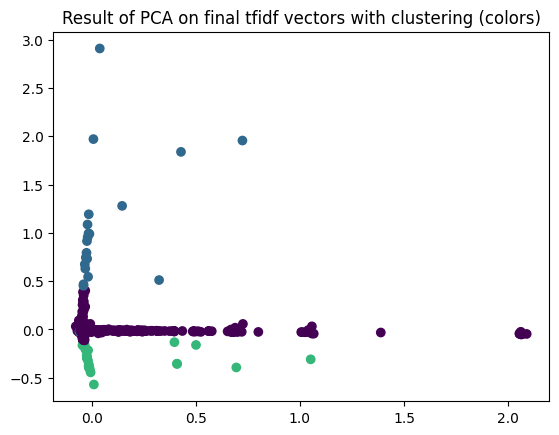

In [298]:

import matplotlib.pyplot as plt
plt.scatter(result_PCA[:,0], result_PCA[:,1], c=label)
plt.title("Result of PCA on final tfidf vectors with clustering (colors)")
plt.show()  


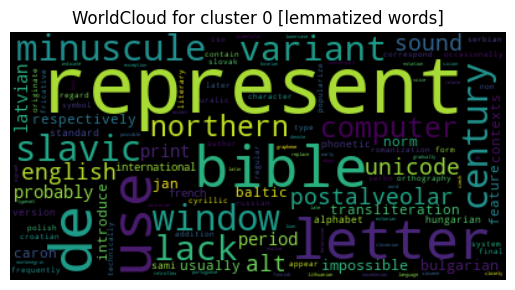

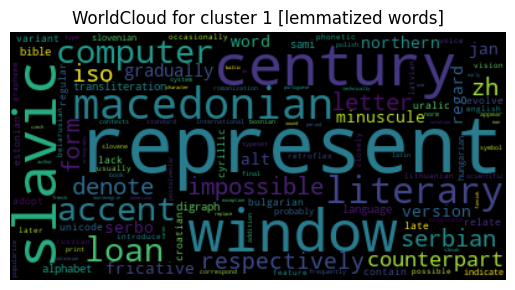

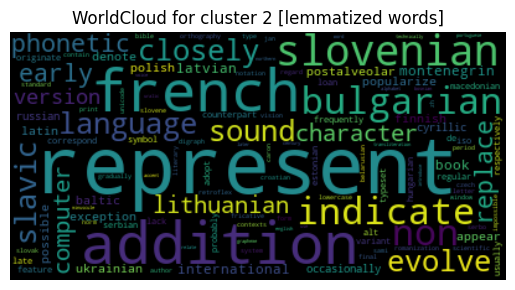

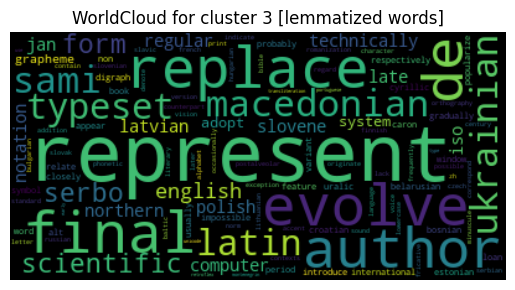

In [299]:
# named entities word cloud depending on the generated Clusters
from wordcloud import WordCloud
from random import shuffle

def flatten(l):
    return [item for sublist in l for item in sublist]

for cluster_label in list(set(label)):
    lems_tc = read_vector_tc(COMPRESSED_TF_LEM)
    idx = [i for lab in label if lab  == cluster_label]
    ne_occurence = dict([(col, lems_tc.loc[idx, col].astype(bool).sum()) for col in lems_tc.columns ])
    temp = flatten([[ne for _ in list(range(occ))] for (ne,occ) in ne_occurence.items()])
    shuffle(temp)
    text = " ".join(temp)
    wordcloud = WordCloud().generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WorldCloud for cluster {cluster_label} [lemmatized words]")
    plt.show()

In [300]:
#ners
ners2 = pd.read_pickle(COMPRESSED_TF_NERS)
ne_count = dict([(col, ners2[col].sum()) for col in ners2.columns])
sorted_ne_count= dict(sorted(ne_count.items(), key=lambda x: x[1], reverse=True))

ne_occurence = dict([(col, ners2[col].astype(bool).sum()) for col in ners2.columns])
sorted_ne_occurence = dict(sorted(ne_occurence.items(), key=lambda x: x[1], reverse=True))

#lems
words_lem = pd.read_pickle(COMPRESSED_TF_LEM)
word_count = dict([(col, words_lem[col].sum()) for col in words_lem.columns])
sorted_word_count= dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True))

word_occurence = dict([(col, words_lem[col].astype(bool).sum()) for col in words_lem.columns])
sorted_word_occurence = dict(sorted(word_occurence.items(), key=lambda x: x[1], reverse=True))


## Histograms

Text(0.5, 1.0, '20 most popular words in dataset of 1870articles (lemmatized, occurence)')

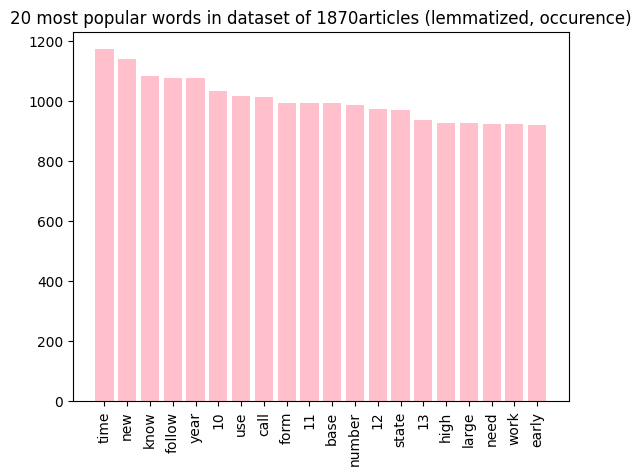

In [301]:
plt.xticks(rotation='vertical')
plt.bar(list(sorted_word_occurence.keys())[:20], list(sorted_word_occurence.values())[:20],color='pink')
plt.title(f"20 most popular words in dataset of {len(document_names)}articles (lemmatized, occurence)")

Text(0.5, 1.0, '20 most popular words in dataset of 1870 articles (lemmatized, count)')

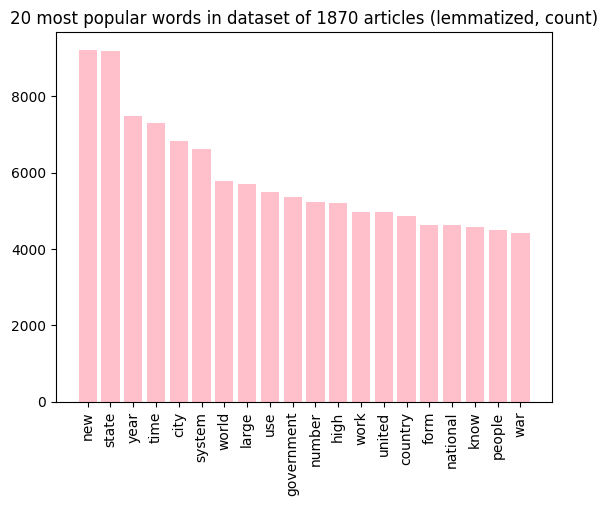

In [302]:
plt.xticks(rotation='vertical')
plt.bar(list(sorted_word_count.keys())[:20], list(sorted_word_count.values())[:20],color='pink')
plt.title(f"20 most popular words in dataset of {len(document_names)} articles (lemmatized, count)")

Text(0.5, 1.0, '20 most popular named entities in dataset of 1870articles (occurence)')

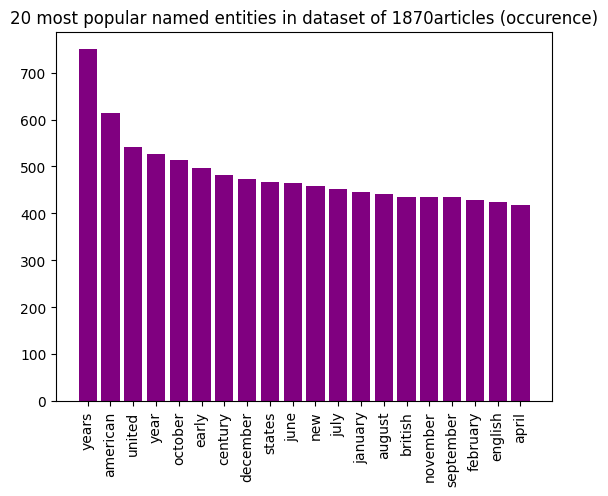

In [303]:
plt.xticks(rotation='vertical')
plt.bar(list(sorted_ne_occurence.keys())[:20], list(sorted_ne_occurence.values())[:20],color='purple')
plt.title(f"20 most popular named entities in dataset of {len(document_names)}articles (occurence)")

Text(0.5, 1.0, '20 most popular named entities in dataset of 1870 articles ( count)')

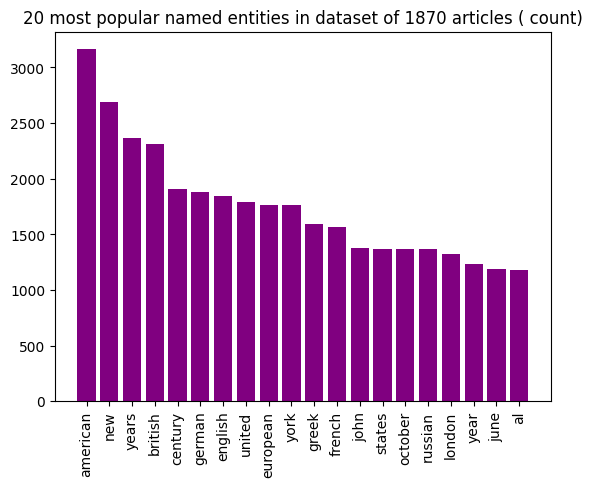

In [304]:
plt.xticks(rotation='vertical')
plt.bar(list(sorted_ne_count.keys())[:20], list(sorted_ne_count.values())[:20],color='purple')
plt.title(f"20 most popular named entities in dataset of {len(document_names)} articles ( count)")

## Comparison of document similarity

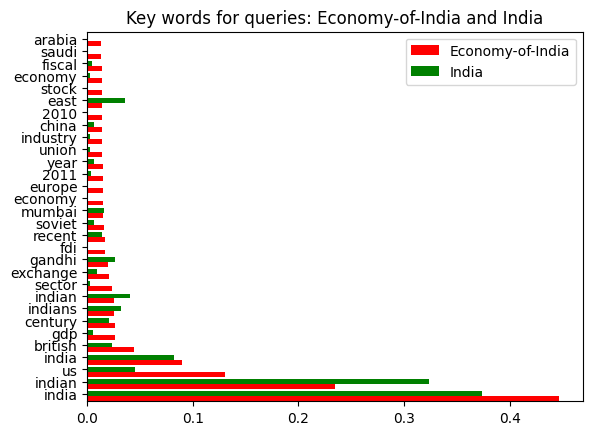

In [306]:
# analysis of vector similarity
# 15 most similar terms of vector A and their tfidf score in A and B
names = list(words_lem.columns) + list(ners2.columns)
vector_A_name = 'Economy-of-India.txt'
vector_B_name = 'India.txt'
idx_A = document_names.index(vector_A_name)
idx_B = document_names.index(vector_B_name)
vector_A = vectors[idx_A]
vector_B = vectors[idx_B]

# most important in vector A
vector_A_dict = dict([(i, value) for i, value in enumerate(vector_A)])
vector_B_dict = dict([(i, value) for i, value in enumerate(vector_B)])
sort_vector = sorted(vector_A_dict.items(), key=lambda x: x[1], reverse=True)
selected_vector_A = [value for i, value in sort_vector[:30]]
selected_vector_B = [vector_B_dict[i] for i, value in sort_vector[:30]]
names = [(names[i]) for i, value in sort_vector[:30]]
df = pd.DataFrame(dict(graph=names,
                            A=selected_vector_A, B=selected_vector_B)) 

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df.A, width, color='red', label=vector_A_name[:-4])
ax.barh(ind + width, df.B, width, color='green', label=vector_B_name[:-4])

ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()
plt.title(f"Key words for queries: {vector_A_name[:-4]} and {vector_B_name[:-4]}")
plt.show()

In [309]:
from scipy.spatial import distance
i = 750
for name, vector_target in list(zip(document_names, vectors))[750:760]:
    distances = distance.cdist([vector_target], vectors - vector_target, "cosine")[0]
    distances[i] = 1000
    min_index = np.argmin(distances)
    #print(distances)
    min_distance = np.argpartition(distances, 2)[2]

    print(f"{name[:-4]} is most similar to {str(document_names[min_index])[:-4]}.")
    i += 1


Impact-factor is most similar to Least-publishable-unit.
Income-inequality-in-the-United-States is most similar to Online-patient-education.
Independence-of-Finland is most similar to INIS-8.
Independent-component-analysis is most similar to Reflexive-relation.
Index-of-Taiwan-related-articles is most similar to Energy-in-Taiwan.
Index-register is most similar to UTF-EBCDIC.
India is most similar to Comparison-between-Indian-states-and-countries-by-GDP-(PPP).
Indiana-Register-of-Historic-Sites-and-Structures is most similar to Inswinger.
Individual is most similar to Inswinger.
Indonesia is most similar to Cikarang.
